# <center>Data Science Project<br/>Deliverable 2: Image processing</center>

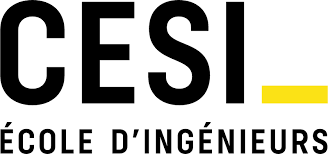

<p>Group: MATOKA FOUNA Ulrich-Tessa, OULD SLIMANE Arslane, Lilou RABOUILLE, </br> TURKY Salma, YEMALEU WOTCHEU Jocelyn</p>

---

## Introduction
In a world where data management is becoming crucial, digitization and automatic document analysis are at the heart of innovation. This project aims to automate the processing of digitized images by developing a solution based on artificial intelligence to automatically generate descriptive captions, thus improving the management and enhancement of visual data.

## TouNum
**TouNum** specializes in digitizing paper documents and converting them into digital format. The company wishes to expand its services by integrating **Machine Learning** tools to automate the classification and generation of captions for digitized images.

![alt text](img/image_caption.png)

## Project presentation
TouNum wishes to develop an image captioning solution capable of analyzing and generating automatic captions. The project also includes binary **classification** to distinguish photos from other types of images. **Pre-processing** will be required to improve image quality before processing by **deep learning** models.

**Deliverables
1.	**Deliverable 1: Binary Classification (Week 3)**
    - Prototype classification model with a report detailing model performance.
2.	**Deliverable 2: Image Preprocessing (Week 4)**
    - Implementation of image pre-processing techniques to improve image quality prior to analysis.
3.	**Deliverable 3: Image Captioning (Week 5)**
    - Complete model integrating binary classification and automatic caption generation, with analysis of results.
4.	**Presentation (End of Project)**
    - 20-minute presentation explaining the workflow, the results obtained, and a question-and-answer session with the TouNum committee.

This project represents an opportunity for **TouNum** to position itself as an innovative leader in the field of digitization, by integrating **Artificial Intelligence** and **Machine Learning** solutions to improve the efficiency of its customers' visual data management.

![alt text](img/project_architecture.png)

## Context
Our team has already created a machine learning model that can recognize a photo from another type of image. Now, in this deliverable, we will focus on improving the quality of a noisy image dataset through advanced preprocessing techniques. This step is crucial as it prepares the dataset for further machine learning tasks by enhancing image clarity and structure. The primary focus is on removing noise from the images to make them more suitable for accurate model training. To achieve this, convolutional autoencoders will be employed as the core technique. This deliverable will outline the steps involved in preprocessing the images, applying denoising algorithms, and evaluating the effectiveness of the methods used.

### Objectives
- Improve the quality of noisy images by applying denoising techniques.
- Utilize convolutional autoencoders for automated and efficient denoising.
- Evaluate the results of the denoising process through visual comparisons and quantitative metrics.

### Challenges
- High computational costs associated with training deep learning models like convolutional autoencoders.
- Balancing noise reduction while preserving important image features and details.
- Ensuring color accuracy in RGB images throughout the denoising process.


## What can you find in this notebook
This notebook will include a comparative study of different autoencoder architectures and the use of different loss functions. The results of the models tested will be stored in a table. 

The architecture of some models can be found in the file [Models](./Models.ipynb) or in [appendix](#annexes) at the end of this notebook. 

<em style="color:red">We can also find various tests carried out on a fully connected architecture in the file [L2_Fully_Connected_Dense_autoencoder](./L2_Fully_Connected_Dense_autoencoder.ipynb) and an explanation of [U-net](#u-net-architecture).</em>

## Environment initialization
### Download project requirements
To ensure that all the team working on the project, as well as the people who want to run the code, use the same virtual environment, we use the `requirements.txt` file. This is a list of the Python packages that need to be installed in a virtual environment for the application to run correctly. 

To run the code, create and activate a virtual environment, then run the following cell.

In [1]:
%pip install -q -r requirements.txt

### Import project librairies

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from onedrivedownloader import download
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
import datetime
import py7zr
import requests
from tensorboard.plugins.hparams import api as hp
import visualkeras

### Enable GPU usage

In [3]:
# import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        # Enable memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

### General functions

In [4]:
# Display the first n images from the dataset
def display_original_images(dataset, n):
    plt.figure(figsize=(10, 10))
    for images in dataset.take(1):  # Take one batch of images
        for i in range(n):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())  # Get the ith image from the batch
            plt.title(f'Image {i+1}')
            plt.axis('off')
    plt.show()

# Display the evolution of the accuracy and loss for train and test datasets
def plot_history(history, epochs=5, metric='accuracy'):
    # Check if the metric exists in the history
    if metric in history.history:
        train_metric = history.history[metric]
        val_metric = history.history[f'val_{metric}']
    else:
        raise KeyError(f'Metric "{metric}" not found in history.')

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))

    # Plot Training and Validation Metric (e.g., SSIM, PSNR, etc.)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_metric, label=f'Training {metric.capitalize()}')
    plt.plot(epochs_range, val_metric, label=f'Validation {metric.capitalize()}')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation {metric.capitalize()}')

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Display test_set, its noisy version and the denoised version
def display_images_results(test_set, dataset, model, n=5):
    plt.figure(figsize=(10, 10))
    for test_set in test_set.take(1):  # Take one batch of images
        for i in range(n):
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(test_set[i].numpy())
            plt.title(f'Original Image {i+1}')
            plt.axis('off')
    plt.show()

    plt.figure(figsize=(10, 10))
    for noisy_images, clean_images in dataset.take(1):  # Take one batch of images
        for i in range(n):
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(noisy_images[i].numpy())  # Get the ith image from the batch
            plt.title(f'Noisy Image {i+1}')
            plt.axis('off')
    plt.show()

    plt.figure(figsize=(10, 10))

    for noisy_images, clean_images in dataset.take(1):  # Take one batch of images
        for i in range(n):
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(model.predict(noisy_images)[i])
            plt.title(f'Denoised Image {i+1}')
            plt.axis('off')
    plt.show()

### Data download

In [5]:
# Fonction pour télécharger le fichier
def download(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        f.write(response.content)

filename = 'dataset/Dataset.7z.001'
folder_to_extract = 'Dataset-L2'
extract_to_path = './dataset_L2'

# Télécharger le fichier si nécessaire
if not os.path.exists('./dataset'):
    url = 'https://viacesifr-my.sharepoint.com/:u:/g/personal/arslane_ouldslimane_viacesi_fr/EYxF-OL6MXVIqY_Jps7fpGMBLUZzrsJajUZ3jHzgImkp_w?e=rvtSN6'

    # Télécharger le fichier
    download(url, filename)

# Extraire uniquement le dossier 'Dataset-L2'
if not os.path.exists(extract_to_path):
    with py7zr.SevenZipFile(filename, 'r') as archive:
        all_files = archive.getnames()
        files_to_extract = [f for f in all_files if f.startswith(folder_to_extract)]
        
        # Extraire les fichiers sélectionnés
        archive.extract(path=extract_to_path, targets=files_to_extract)

# Supprimer le fichier téléchargé
if os.path.exists(filename):
    os.remove(filename)


### Data cleansing

In [6]:
from images_check import clean_dataset

if not os.path.exists('dataset_L2_clean/'):
    input_path = 'dataset_L2/'
    output_path = 'dataset_L2_clean/'
    clean_dataset(input_path, output_path)

In [7]:
image_w = 128
image_h = 128
batch_s = 16
EPOCHS = 100

dir_path = './dataset_L2_clean/'

### Labels as Images
In this autoencoder-based preprocessing step, <em style="color:red">the labels are the images themselves</em>. This means that the model is not predicting a different class or category but is learning to reconstruct the input images in a cleaner or denoised form. The autoencoder is trained to minimize the difference between the input (noisy) and output (denoised) images, making it suitable for tasks like noise reduction or image enhancement.

### Creation of a non-augmented dataset

In this section, we will split the dataset into training and testing subsets. This process utilizes TensorFlow's built-in capabilities to create two distinct datasets from the provided directory, ensuring that images are randomly assigned to either the training or testing set. We ensure that the model is trained and evaluated on distinct subsets of the data, thus avoiding overfitting and guaranteeing a fair assessment of model performance.

In [8]:
def split_dataset(dir_path, image_h, image_w, batch_s, split=0.2):
    # split the dataset into training and testing
    train_set = tf.keras.preprocessing.image_dataset_from_directory(
        dir_path,
        validation_split=split,
        subset='training',
        seed=42,        
        image_size=(image_h, image_w),
        batch_size=batch_s,
        label_mode=None,
        shuffle=False
    )

    test_set = tf.keras.preprocessing.image_dataset_from_directory(
        dir_path,
        validation_split=split,
        subset='validation',
        seed=42,
        image_size=(image_h, image_w),
        batch_size=batch_s,
        label_mode=None,
        shuffle=False
    )
    return train_set, test_set

train_set, test_set = split_dataset(dir_path, image_h, image_w, batch_s)

The dataset contains a total of 148 image files, all belonging to a single class. For training purposes, 119 files (approximately 80%) are used, while 29 files (about 20%) are allocated for validation. This division ensures that the model can effectively learn from the majority of the data while still having a separate set to evaluate its performance and generalization during training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE # Use the maximum number of parallel calls to improve performance of the input pipeline (https://www.tensorflow.org/guide/data_performance)

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# divide train_set by 255 to normalize the data
train_set = train_set.map(lambda x: x / 255.)
test_set = test_set.map(lambda x: x / 255.)

As we have seen, we have very little data in our dataset. Thus, the future model might struggle to learn a wide variety of patterns, leading it to memorize the training examples instead of learning generalized features.

We will generate a new dataset by using techniques such as random flipping, rotation, and zooming to artificially increase the size of your training dataset and introduce more variety. We will use this dataset later on.

### Creating an augmented dataset

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dir_path,
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    label_mode=None,
)

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

# augment the dataset
augmented_dataset = dataset.map(lambda x: data_augmentation(x))

In [13]:
# Displaying images augmented_dataset
plt.figure(figsize=(5, 5))
for images in augmented_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [14]:
dataset.cardinality().numpy()

In [15]:
# add augmentation to the dataset
dataset_augmented = dataset.concatenate(augmented_dataset) # concatenate the original and augmented dataset
dataset_augmented.cardinality().numpy() 

We doubled the size of the dataset.

In [16]:
split=0.2

train_size = int((1-split) * dataset_augmented.cardinality().numpy()) # 80% of the dataset
test_size = int(split * dataset_augmented.cardinality().numpy()) # 20% of the dataset

train_ds_augmented = dataset_augmented.take(train_size)
test_ds_augmented = dataset_augmented.skip(train_size)

In [17]:
train_ds_augmented = train_ds_augmented.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # shuffle the dataset and cache it in memory for faster training
test_ds_augmented = test_ds_augmented.cache().prefetch(buffer_size=AUTOTUNE) # cache the dataset in memory for faster training

In [18]:
# divide train_set by 255 to normalize the data
train_ds_augmented = train_ds_augmented.map(lambda x: x / 255.)
test_ds_augmented = test_ds_augmented.map(lambda x: x / 255.)

### Display Dataset

In [19]:
display_original_images(train_set, 9)

### Noisy images
Let's noisy versions of the input images. This is done as part of training a denoising autoencoder, where the goal is for the model to learn how to remove noise and reconstruct the original clean images. The function add_noise is used to add random noise to the images. The noise factor determines the amount of noise added to the images.

In [20]:
# Put noise in the images put not the same amount of noise in all images if same_noise is False
def add_noise(images, noise_factor=0.3, same_noise=True):
    if same_noise:
        noisy_images = images + noise_factor * tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=1.0)
    else:
        noise_factor = tf.random.uniform(shape=[], minval=0.2, maxval=0.5)
        noisy_images = images + noise_factor * tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=1.0)
    noisy_images = tf.clip_by_value(noisy_images, clip_value_min=0.0, clip_value_max=1.0)
    return noisy_images

In [21]:
noisy_train_set = train_set.map(lambda x: (add_noise(x), x))  # Noisy input, clean target
noisy_test_set = test_set.map(lambda x: (add_noise(x), x))    # Noisy input, clean target

In [22]:
noisy_train_ds_augmented = train_ds_augmented.map(lambda x: (add_noise(x), x))  # Noisy input, clean target
noisy_test_ds_augmented = test_ds_augmented.map(lambda x: (add_noise(x), x))    # Noisy input, clean target

### Display Images

In [23]:
def display_images(dataset, n):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):  # Take one batch of images
        for i in range(n):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())  # Get the ith image from the batch
            plt.title(f'Image {i+1}')
            plt.axis('off')
    plt.show()

In [24]:
display_images(noisy_train_set, 9)

### Gaussian Blur

In this code, a Gaussian blur is applied to images using a custom 2D Gaussian kernel, created through the gaussian_kernel function. Gaussian blur is chosen because it effectively reduces noise and smooths out detail while preserving the overall structure of the image. The Gaussian kernel assigns more weight to pixels near the center, resulting in a natural blur effect. The gaussian_blur function applies this kernel via a depthwise convolution in TensorFlow, ensuring that the blur is applied to both grayscale and RGB images without distorting their original dimensions. This technique is useful in preprocessing images, reducing noise before further analysis or feature extraction.


In [ ]:
import numpy as np
import tensorflow as tf

def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    """Create a 2D Gaussian kernel.
    
    Parameters:
    - size: Size of the kernel (should be odd).
    - sigma: Standard deviation for the Gaussian distribution.
    
    Returns:
    - A 2D numpy array representing the Gaussian kernel.
    """
    kernel_range = np.arange(-size // 2 + 1., size // 2 + 1.)  # Create a range for kernel
    x, y = np.meshgrid(kernel_range, kernel_range)  # Create a meshgrid for 2D coordinates
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))  # Calculate Gaussian values
    kernel = kernel / np.sum(kernel)  # Normalize the kernel so that the sum is 1
    return kernel

def gaussian_blur(images, kernel_size=5, sigma=1.0):
    """
    Apply Gaussian blur to the images using a Gaussian kernel.

    Parameters:
    - images: Input images tensor (shape: [N, H, W, C]). Supports both grayscale (C=1) and RGB (C=3) images.
    - kernel_size: Size of the Gaussian kernel (default is 5).
    - sigma: Standard deviation for the Gaussian kernel (default is 1.0).

    Returns:
    - Blurred images tensor with the same shape as input.
    """
    # Create a Gaussian kernel
    kernel = gaussian_kernel(kernel_size, sigma)  # Generate the Gaussian kernel
    kernel = np.expand_dims(kernel, axis=-1)  # Add channel dimension for the kernel
    kernel = np.expand_dims(kernel, axis=-1)  # Add batch dimension for the kernel
    kernel = tf.convert_to_tensor(kernel, dtype=tf.float32)  # Convert the kernel to a TensorFlow tensor

    # Reshape for conv2d (depth should match the number of input channels)
    input_channels = images.shape[-1]  # Get the number of channels in the input images
    kernel = tf.reshape(kernel, (kernel_size, kernel_size, 1, 1))  # Reshape kernel for conv2d
    kernel = tf.tile(kernel, [1, 1, input_channels, 1])  # Tile kernel for each input channel

    # Apply convolution
    blurred_images = tf.nn.depthwise_conv2d(images, kernel, strides=[1, 1, 1, 1], padding='SAME')  # Apply depthwise convolution

    # Ensure the output has the same number of channels as the input
    blurred_images = tf.image.resize(blurred_images, [images.shape[1], images.shape[2]])  # Resize to match input dimensions
    blurred_images = tf.clip_by_value(blurred_images, 0.0, 1.0)  # Ensure values are within [0, 1]

    return blurred_images  # Return the blurred images tensor


## Tensorboard setting

In [25]:
%load_ext tensorboard

In [26]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) # to be put in model.fit callbacks

## Autoencoder
### What is an Autoencoder?

An **autoencoder** is a neural network designed to learn a compressed, lower-dimensional representation of the input data. The goal is to encode the input into a compact form (called a **latent space**) and then reconstruct the input as closely as possible from this representation.

An autoencoder consists of two main parts:
- **Encoder**: Compresses the input data into a smaller representation.
- **Decoder**: Reconstructs the original data from the compressed representation.

The network learns this compression and reconstruction by minimizing the difference between the input and the output.

#### General Architecture of an Autoencoder:

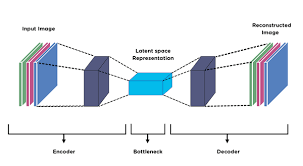

### Why are Autoencoders Important?
Autoencoders are important for several reasons in the context of deep learning:

- __Dimensionality Reduction__: They reduce the complexity of data, making it easier for downstream tasks like classification or clustering.

- __Data Compression__: Autoencoders can be used to compress data (such as images or text) for efficient storage.

- __Denoising__: Autoencoders can clean noisy data by learning to ignore irrelevant information and reconstruct cleaner versions of the input.

- __Anomaly Detection__: Autoencoders can detect anomalies by comparing the reconstructed output with the original input.

- __Autoencoders__ learn the most relevant features of data, making them useful for pre-processing in many machine learning pipelines.

It's this usefulness for `denoising` that will interest us in this notebook.

### How Does an Autoencoder Work?
The autoencoder learns two functions during training:

Encoding: The encoder compresses the input  𝑥 into a latent representation ℎ

The autoencoder learns two functions during training:

- **Encoding**: The encoder compresses the input $z$ into a latent representation $h$.
  
  $h = f(z)$

- **Decoding**: The decoder reconstructs the input from the latent representation $h$, generating the output $\hat{x}$.

  $\hat{x} = g(h)$

The objective is to minimize the reconstruction loss, usually computed as the mean squared error (MSE) between the input $z$ and the reconstructed output $\hat{x}$:

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{x}_i)^2
$$

This forces the autoencoder to learn the most important features of the data while discarding noise and redundancy.

In the rest of this notebook, we'll explore __different autoencoder architectures__ and __loss functions__. The latter will have a __major impact on image reconstruction quality__. Depending on the type of autoencoder (`classical`, `convolutional`, `variational`, etc.) and the loss function chosen, the autoencoder can be more or less effective in capturing important image features while minimizing information loss.

### Function to test the model on an image

We test the different models on the test set. However, we can also use the following function to compare models on a given image.

In [27]:
def test_model_on_image(path, model, model_name):
    img = tf.keras.preprocessing.image.load_img(path, target_size=(image_h, image_w))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    noisy_img = add_noise(img_array)
    denoised_img = model.predict(noisy_img)
    display_images_results(noisy_img, img_array, model, n=1)

    # save results in results/{model_name}.png
    plt.imsave(f'results/{model_name}.png', denoised_img[0]) 

### Optimizers
In the context of training neural networks, including autoencoders for denoising tasks, the <em style="color:red">optimizer plays a crucial role in guiding the learning process</em>. Its primary function is to minimize the loss function, which quantifies the difference between the predicted output (i.e., the denoised image) and the actual output (the clean image). By iteratively adjusting the model's weights and biases based on the gradients computed during backpropagation, the optimizer helps the model learn the most effective representations of the input data to enhance denoising performance. A well-chosen optimizer can significantly influence the convergence speed and overall effectiveness of the training process, ultimately affecting the quality of the denoised images produced by the autoencoder.

Choosing the right optimizer is essential for successfully training an autoencoder for denoising tasks. The optimizer affects not only how quickly and effectively the model learns but also the final quality of the reconstructed images. For tasks such as image denoising, optimizers like Adam or RMSprop are often favored for their adaptive learning rate features, helping the model to converge efficiently while navigating the complexities of the loss landscape.

These optimizers include, among many others:
- Stochastic Gradient Descent (SGD): SGD is one of the most basic and widely used optimization algorithms. It updates the model's parameters by calculating the gradient of the loss function with respect to the parameters for a small batch of data, rather than the entire dataset. While SGD can converge to good solutions, it often requires careful tuning of the learning rate and may converge slowly.

- RMSprop: RMSprop is designed to combat the diminishing learning rate issue present in Adagrad. It maintains a moving average of the squared gradients, which helps to adapt the learning rates and allows the model to continue learning over time. This optimizer is particularly effective in non-stationary environments, making it a popular choice for training neural networks.

- Adam: Adam (Adaptive Moment Estimation) combines the advantages of both RMSprop and momentum by maintaining moving averages of both the gradients and their squares. This results in adaptive learning rates for each parameter, making Adam one of the most popular optimizers in deep learning. It is robust to different types of data and works well across a variety of tasks, including denoising.

- AdamW: AdamW is a variant of Adam that decouples weight decay from the optimization step. Traditional Adam applies weight decay during the parameter update, which can lead to suboptimal performance. AdamW, on the other hand, applies weight decay directly to the parameters, resulting in improved regularization and performance in many cases.

### Choice of the metrics and loss function

For our purpose of denoising images, we need to choose metrics and loss functions that are suitable for image reconstruction tasks. It is important to select metrics that can effectively evaluate the quality of the reconstructed images and <em style="color:red">loss functions that can guide the training process to minimize reconstruction errors</em>. **Accuracy**, which we used for classification tasks, is not suitable for image reconstruction tasks. So, so relevant metrics & loss functions were chosen.

#### Metrics
- **Mean Absolute Error (MAE)(L1 Loss)**: 

    L1 Loss, also known as the Mean Absolute Error (MAE) loss, calculates the absolute difference between predicted and actual values. This loss is less sensitive to outliers and can be a better choice when dealing with data that exhibits significant variations. The mathematics behind L1 Loss is as simple as its name suggests — it’s the mean of the absolute differences between the predicted and true values.

    L1 Loss is calculated as:

    $$ l1 = {{1 \over n} \sum^{n}_{i=1} |Y_i - \hat Y_i|} $$

    MAE is robust to outliers and provides a more intuitive measure of reconstruction error compared to MSE. MAE can be used as a **metric** to evaluate the quality of the reconstructed images **as well as a loss function during training**.

- **Peak Signal-to-Noise Ratio (PSNR)**: 

    PSNR (Peak Signal-to-Noise Ratio) measures how much a signal (like an image or video) has been affected by noise or distortion, usually after compression. It compares the original signal's quality to the compressed one. Higher PSNR values mean the compressed image or video is closer to the original and has better quality. It's often expressed in decibels (dB) for easier understanding.

    PSNR is calculated as:
    $$ PSNR = 20 * \log_{10}(MAX_I) - 10 * \log_{10}(MSE) $$

    Here, $MAX_I$ is the maximum possible pixel value of the image.

- **Structural Similarity Index Measure (SSIM)**:

    SSIM (Structural Similarity Index Measure) is a way to compare how similar two images are, based on how we perceive them visually. It’s used to judge the quality of images and videos, especially after they’ve been compressed. SSIM works by comparing the structure of the images, taking into account how pixel values depend on each other, especially when they are close together. It also considers how brightness (luminance) and texture (contrast) affect how we notice changes in the image.

    Unlike other methods like PSNR or MSE, which measure exact differences between images, SSIM focuses on changes that are more meaningful to human perception, making it a better indicator of how much an image has been degraded in a way that we would notice.

    The SSIM index is calculated on various windows of an image. The measure between two windows $x$ and $y$ of common size $N × N$ is:

    $$ {\displaystyle {\hbox{SSIM}}(x,y)={\frac {(2\mu _{x}\mu _{y}+c_{1})(2\sigma _{xy}+c_{2})}{(\mu _{x}^{2}+\mu _{y}^{2}+c_{1})(\sigma _{x}^{2}+\sigma _{y}^{2}+c_{2})}}}$$

    with:

    - ${\displaystyle \mu _{x}}$ the pixel sample mean of $x$;
    - ${\displaystyle \mu _{y}}$ the pixel sample mean of ${\displaystyle y}$;
    - ${\displaystyle \sigma _{x}^{2}}$ the variance of ${\displaystyle x}$;
    - ${\displaystyle \sigma _{y}^{2}}$ the variance of ${\displaystyle y}$;
    - ${\displaystyle \sigma _{xy}}$ the covariance of ${\displaystyle x}$ and ${\displaystyle y}$;
    - ${\displaystyle c_{1}=(k_{1}L)^{2}}$, ${\displaystyle c_{2}=(k_{2}L)^{2}}$ two variables to stabilize the division with weak denominator;
    - ${\displaystyle L}$ the dynamic range of the pixel-values (typically this is ${\displaystyle 2^{\#bits\ per\ pixel}-1}$);
    - ${\displaystyle k_{1}=0.01}$ and ${\displaystyle k_{2}=0.03}$ by default.

    SSIM can be used both as a **metric** to evaluate the quality of the reconstructed images and as a **loss function during training**.

#### Loss Functions
- **Mean Squared Error (MSE)**: 

    MSE (Mean Squared Error) is a common metric used to measure the average squared difference between the original and reconstructed images. It calculates the average of the squared differences between the pixel values of the original and reconstructed images. Lower MSE values indicate better reconstruction quality.

    MSE is calculated as:

    $$ MSE = \frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{x}_i)^2 $$

    MSE is sensitive to outliers and can be influenced by large errors, making it less robust to noise. However, it is widely used due to its simplicity and ease of interpretation.

    MSE can also be used as a loss function during training to guide the optimization process. But it may not always correlate well with human perception of image quality. It will be tested against the other loss functions to see which one performs best.

- **Binary Cross-Entropy (BCE)**: 

    BCE (Binary Cross-Entropy) is a loss function commonly used for binary classification tasks. It measures the difference between two probability distributions: the predicted probability distribution output by the model and the true probability distribution of the labels. BCE is often used in autoencoders for binary image reconstruction tasks. **But since we are dealing with RGB images, we will not use this loss function.**

- **Structural Similarity Index Measure (SSIM)**:

    As mentioned earlier, SSIM can be used both as a metric to evaluate the quality of the reconstructed images and as a loss function during training. SSIM loss can guide the optimization process to minimize the structural differences between the original and reconstructed images, focusing on perceptually important features.

- **Multi-Scale Structural Similarity Index Measure (MS-SSIM)**:

    MS-SSIM (Multi-Scale SSIM) is an advanced version of SSIM that looks at an image at different levels of detail (or scales). It works by checking the similarity between two images at various resolutions, simulating how our eyes process visual information at different levels of detail. By doing this, MS-SSIM can better capture differences in quality across the whole image, making it more accurate than regular SSIM when judging the quality of images and videos. This method is often better at predicting how humans perceive image quality. But, due to its complexity, it is computationally more expensive than SSIM and thus will not be used in this notebook due to memory constraints.

- **Mixed Loss Function**:

    A mixed loss function combines multiple loss functions to leverage the strengths of each. For example, a mixed loss function can combine L1 and SSIM to balance the reconstruction accuracy and perceptual quality of the reconstructed images. By using a mixed loss function, we can guide the optimization process to minimize both pixel-wise differences and structural differences between the original and reconstructed images.

    Based on [research done by NVidia](https://research.nvidia.com/sites/default/files/pubs/2017-03_Loss-Functions-for/NN_ImgProc.pdf) on loss functions for image reconstruction tasks, a mixed loss function combining L1 and MS-SSIM can provide better results than using either loss function individually. MS-SSIM is good at preserving image structure and contrast in high-frequency regions, which helps with sharpness and details, while L1 helps retain accurate luminance and color information, reducing color shifts and brightness issues that MS-SSIM alone might introduce. By balancing the contributions of both, the mixed loss function improves overall image quality, addressing artifacts like noise and splotchiness better than using either loss function individually​

To compare the performance of the different loss functions, we will train simple autoencoder models using each loss function and evaluate the quality of the reconstructed images using the selected metrics.

In [28]:
def ssim_loss(y_true, y_pred):
    # Compute the SSIM loss
    SSIM = tf.image.ssim(y_true, y_pred, max_val=1.0) #, filter_size=(image_h//(2**4)))
    # SSIM is in the range [0, 1], so we return 1 - SSIM as the loss
    return 1 - SSIM

def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def combined_loss(y_true, y_pred):
    return ssim_loss(y_true, y_pred) + l1_loss(y_true, y_pred)

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)  # Assuming image pixel values are normalized between 0 and 1

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)  # Assuming image pixel values are normalized between 0 and 1

def l1_metric(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

We're going to test these various loss functions on a denoising autoencoder. This test will enable us to determine which one to use to obtain the best results.

#### Denoising Autoencoder (DAE)
Let's start with the __denoising autoencoder__ (DAE). This is an autoencoder in which the __encoder__ progressively extracts important features using convolution layers (`keras.layers.Conv2D`). After each convolution layer, the image width is reduced with polling layers (`keras.layers.MaxPooling`). In the DAE encoder, the aim is to capture the essential information while suppressing noise.

At the encoder output, the image is represented in the form of a compact feature map containing the information required for image reconstruction. This is the __latent space__.

This digest of features is taken up by the __decoder__, which reconstructs the original image by applying convolution and magnification layers to gradually restore the image to its original size.

As with the other models, during training, the denoised image at output is compared with the original un-noised image. Weights are then adjusted. 

Here's the basis of the unoptimized model:

In [29]:
# Build the Denoising Autoencoder (DAE) model
def build_denoising_autoencoder(input_shape=(128, 128, 3)):
    # Encoder
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

#### MSE

In [30]:
autoencoder_mse = build_denoising_autoencoder(input_shape=(image_h, image_w, 3))
autoencoder_mse.compile(optimizer='adam', loss='mean_squared_error', metrics=[psnr_metric, ssim_metric, l1_metric])

autoencoder_mse.summary()

In [31]:
visualkeras.layered_view(autoencoder_mse, to_file=None, legend=True)

In [32]:
# Train the autoencoder
history_mse = autoencoder_mse.fit(noisy_train_set, epochs=EPOCHS, validation_data=noisy_test_set,
                          callbacks=[tensorboard_callback])

In [33]:
plot_history(history_mse, EPOCHS, metric='psnr_metric')

In [34]:
display_images_results(test_set, noisy_test_set, autoencoder_mse, 5)

#### L1 Loss

In [35]:
autoencoder_l1 = build_denoising_autoencoder(input_shape=(image_h, image_w, 3))
autoencoder_l1.compile(optimizer='adam', loss=l1_loss, metrics=[psnr_metric, ssim_metric, l1_metric])

autoencoder_l1.summary()

In [36]:
# Train the autoencoder
history_l1 = autoencoder_l1.fit(noisy_train_set, epochs=EPOCHS, validation_data=noisy_test_set,
                          callbacks=[tensorboard_callback])

In [37]:
plot_history(history_l1, EPOCHS, metric='psnr_metric')

In [38]:
display_images_results(test_set, noisy_test_set, autoencoder_l1, 5)

#### SSIM

In [39]:
autoencoder_ssim = build_denoising_autoencoder(input_shape=(image_h, image_w, 3))
autoencoder_ssim.compile(optimizer='adam', loss=ssim_loss, metrics=[psnr_metric, ssim_metric, l1_metric])

history_ssim = autoencoder_ssim.fit(noisy_train_set, epochs=EPOCHS, validation_data=noisy_test_set,
                          callbacks=[tensorboard_callback])

In [40]:
plot_history(history_ssim, EPOCHS, metric='psnr_metric')

In [52]:
display_images_results(test_set, noisy_test_set, autoencoder_ssim, 5)

#### Mixed Loss Function

In [42]:
autoencoder_hybride = build_denoising_autoencoder(input_shape=(image_h, image_w, 3))
autoencoder_hybride.compile(optimizer='adam', loss=combined_loss, metrics=[psnr_metric, ssim_metric, l1_metric])

history_hybride = autoencoder_hybride.fit(noisy_train_set, epochs=EPOCHS, validation_data=noisy_test_set,
                          callbacks=[tensorboard_callback])

In [43]:
plot_history(history_hybride, EPOCHS, metric='psnr_metric')

In [44]:
display_images_results(test_set, noisy_test_set, autoencoder_hybride, 5)

#### With data augmentation

As we saw earlier, our dataset is small, which may lead the model to memorize particular examples instead of learning generalizable patterns. We may also have inconsistent performance, as the model will be sensitive to random fluctuations in the data. Using overly complex models can lead to rapid over-fitting.

That's why we're going to run our model and observe the results with the augmented training and test datasets defined above, `noisy_train_ds_augmented` and `noisy_test_ds_augmented`to determine whether it would be better to train our models on more data.

##### AUG MSE

In [45]:
autoencoder_augmented_mse = build_denoising_autoencoder(input_shape=(image_h, image_w, 3))
autoencoder_augmented_mse.compile(optimizer='adam', loss='mse', metrics=[psnr_metric, ssim_metric, l1_metric])

history_augmented_mse = autoencoder_augmented_mse.fit(noisy_train_ds_augmented, epochs=EPOCHS, validation_data=noisy_test_ds_augmented,
                          callbacks=[tensorboard_callback])

##### AUG L1 Loss

In [46]:
autoencoder_augmented_l1 = build_denoising_autoencoder(input_shape=(image_h, image_w, 3))
autoencoder_augmented_l1.compile(optimizer='adam', loss=l1_loss, metrics=[psnr_metric, ssim_metric, l1_metric])

history_augmented_l1 = autoencoder_augmented_l1.fit(noisy_train_ds_augmented, epochs=EPOCHS, validation_data=noisy_test_ds_augmented,
                          callbacks=[tensorboard_callback])

##### AUG SSIM

In [47]:
autoencoder_augmented_ssim = build_denoising_autoencoder(input_shape=(image_h, image_w, 3))
autoencoder_augmented_ssim.compile(optimizer='adam', loss=ssim_loss, metrics=[psnr_metric, ssim_metric, l1_metric])

history_augmented_ssim = autoencoder_augmented_ssim.fit(noisy_train_ds_augmented, epochs=EPOCHS, validation_data=noisy_test_ds_augmented,
                          callbacks=[tensorboard_callback])

##### AUG Mixed Loss

In [48]:
autoencoder_augmented_hybride = build_denoising_autoencoder(input_shape=(image_h, image_w, 3))
autoencoder_augmented_hybride.compile(optimizer='adam', loss=combined_loss, metrics=[psnr_metric, ssim_metric, l1_metric])

history_augmented_hybride = autoencoder_augmented_hybride.fit(noisy_train_ds_augmented, epochs=EPOCHS, validation_data=noisy_test_ds_augmented,
                          callbacks=[tensorboard_callback])

In [49]:
print('AUG MSE:')
plot_history(history_augmented_mse, EPOCHS, metric='psnr_metric')
print('AUG L1:')
plot_history(history_augmented_l1, EPOCHS, metric='psnr_metric')
print('AUG SSIM:')
plot_history(history_augmented_ssim, EPOCHS, metric='psnr_metric')
print('AUG Hybride:')
plot_history(history_augmented_hybride, EPOCHS, metric='psnr_metric')

In [50]:
print('MSE:')
display_images_results(test_set, noisy_test_set, autoencoder_augmented_mse, 5)
print('L1:')
display_images_results(test_set, noisy_test_set, autoencoder_augmented_l1, 5)
print('SSIM:')
display_images_results(test_set, noisy_test_set, autoencoder_augmented_ssim, 5)
print('Hybride:')
display_images_results(test_set, noisy_test_set, autoencoder_augmented_hybride, 5)

Nous notons une nette amélioration du modèle maintenant que nous l'entraînons et généralisons sur plus de données.

### U-Net Architecture

The U-Net model is a convolutional neural network architecture commonly used for image segmentation tasks. It is designed to learn detailed spatial information while preserving the overall context of the image. The architecture consists of two main paths:

* Contracting Path (Encoder): This path progressively reduces the spatial dimensions of the image using convolution and max-pooling layers, allowing the model to capture high-level features and context. Each layer captures increasingly complex patterns, from low-level details to broader structures.

* Expanding Path (Decoder): This path performs up-sampling through transposed convolutions (or deconvolutions) to restore the original resolution of the image. The key idea of U-Net is that it concatenates the feature maps from the contracting path to the corresponding layers in the expanding path, allowing for precise localization of image features.

In this implementation, the model takes a 128x128 RGB image as input and outputs a segmented RGB image.



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_shape):
    # Define the input layer with the specified shape
    inputs = layers.Input(shape=input_shape)

    # **Contracting Path**
    # First convolutional block (64 filters, 3x3 kernel size, ReLU activation, 'same' padding)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    # MaxPooling to downsample the feature maps
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Second convolutional block (128 filters)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    # MaxPooling
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Third convolutional block (256 filters)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    # MaxPooling
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # **Bottleneck**
    # Deepest layer (512 filters)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # **Expansive Path**
    # First upsampling block
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    # Concatenate with the corresponding feature map from the contracting path
    u5 = layers.concatenate([u5, c3])
    # Convolutional layers after upsampling
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Second upsampling block
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])  # Concatenation
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    # Third upsampling block
    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])  # Concatenation
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    # **Output Layer**
    # 1x1 convolution to produce the final output (RGB image with 3 channels)
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c7)  # 3 channels for RGB output

    # Create the model with specified inputs and outputs
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Define the input shape
input_shape = (128, 128, 3)  # Example input shape
# Create the U-Net model
model = unet_model(input_shape)


**2D Convolutions with ReLU activation:** These layers are used to extract features and introduce non-linearity into the model, allowing it to learn complex patterns.

**'Same' Padding**: Ensures that the output dimensions are the same as the input dimensions, which is crucial for concatenation in the expansive path.

**MaxPooling**: Reduces the image size while preserving important features, thus increasing the receptive field and allowing the network to capture more contextual information.

**De-convolutions (Up-convolutions)**: Used to restore the image size during reconstruction, while preserving details through concatenation with the contracting path.

**Output layer with sigmoid activation:** This is suitable for image segmentation problems where the output needs to be normalized between 0 and 1 for each pixel.

The U-Net architecture is particularly well-suited for image segmentation tasks, as it effectively captures both local details and contextual information at various scales.

In [ ]:
# Loop through the noisy training set to inspect the shape of inputs and outputs
for x, y in noisy_train_set.take(1):  
    print("Shape of input:", x.shape)  
    print("Shape of output:", y.shape) 

# Loop through the noisy test set to inspect the shape of inputs and outputs
for x, y in noisy_test_set.take(1):  
    print("Shape of input:", x.shape)  
    print("Shape of output:", y.shape)  


--> The input and output shapes indicate that the model processes batches of images with consistent dimensions. For the first batch, there are 32 images, each measuring 128x128 pixels with 3 color channels (RGB), and the model produces an identical output shape of 32 images with the same dimensions. In the second batch, there are 29 images, also with dimensions of 128x128 pixels and 3 channels, resulting in an output that mirrors these dimensions.

In [ ]:
# Import the AUC metric from TensorFlow
from tensorflow.keras.metrics import AUC  

# Compile the model with Adam optimizer, custom SSIM loss, and additional metrics (AUC and MAE)
model.compile(optimizer='adam', loss=ssim_loss, metrics=[AUC(), 'mae']) 


In [ ]:
# Train the model on the noisy training set
history = model.fit(noisy_train_set,
                    epochs=15,  # Number of epochs to train, adjust based on needs
                    validation_data=noisy_test_set,  # Validate on the noisy test set
                    callbacks=[tensorboard_callback],  # TensorBoard callback for visualization
                    verbose=1)  # Verbose 1 for progress bar during training, 0 for silent mode


Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 194s 45s/step - auc_2: 0.5310 - loss: 0.7420 - mae: 0.2388 - val_auc_2: 0.8891 - val_loss: 0.6609 - val_mae: 0.2260
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 176s 45s/step - auc_2: 0.8425 - loss: 0.6554 - mae: 0.2140 - val_auc_2: 0.8204 - val_loss: 0.5596 - val_mae: 0.1283
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 168s 42s/step - auc_2: 0.7877 - loss: 0.5744 - mae: 0.2013 - val_auc_2: 0.8252 - val_loss: 0.6204 - val_mae: 0.1385
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 202s 42s/step - auc_2: 0.7976 - loss: 0.5536 - mae: 0.1517 - val_auc_2: 0.9268 - val_loss: 0.5134 - val_mae: 0.1530
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 176s 45s/step - auc_2: 0.8029 - loss: 0.5122 - mae: 0.1298 - val_auc_2: 0.9261 - val_loss: 0.4940 - val_mae: 0.1113
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 175s 45s/step - auc_2: 0.8808 - loss: 0.4837 - mae: 0.1155 - val_auc_2: 0.9361 - val_loss: 0.4832 - val_mae: 0.1089
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 194s 42s/step - auc_2: 0.8926 - loss: 0.4795 - mae: 0.1052 - val_auc_2: 0.9408 - val_loss: 0.4833 - val_mae: 0.1105
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 201s 42s/step - auc_2: 0.8739 - loss: 0.4698 - mae: 0.1052 - val_auc_2: 0.9400 - val_loss: 0.4793 - val_mae: 0.1000
Epoch 9/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 175s 45s/step - auc_2: 0.9067 - loss: 0.4614 - mae: 0.0977 - val_auc_2: 0.9449 - val_loss: 0.4655 - val_mae: 0.1087
Epoch 10/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 193s 42s/step - auc_2: 0.8902 - loss: 0.4556 - mae: 0.1048 - val_auc_2: 0.9481 - val_loss: 0.4665 - val_mae: 0.0979
Epoch 11/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 167s 42s/step - auc_2: 0.8740 - loss: 0.4623 - mae: 0.0954 - val_auc_2: 0.9499 - val_loss: 0.4618 - val_mae: 0.1035
Epoch 12/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 167s 42s/step - auc_2: 0.8553 - loss: 0.4568 - mae: 0.0990 - val_auc_2: 0.9490 - val_loss: 0.4622 - val_mae: 0.1080
Epoch 13/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 210s 45s/step - auc_2: 0.8967 - loss: 0.4505 - mae: 0.1033 - val_auc_2: 0.9511 - val_loss: 0.4543 - val_mae: 0.0940
Epoch 14/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 167s 42s/step - auc_2: 0.9128 - loss: 0.4459 - mae: 0.0931 - val_auc_2: 0.9524 - val_loss: 0.4472 - val_mae: 0.0937
Epoch 15/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 176s 45s/step - auc_2: 0.8938 - loss: 0.4417 - mae: 0.0916 - val_auc_2: 0.9530 - val_loss: 0.4463 - val_mae: 0.093

In [ ]:
# AUC
plt.plot(history.history['auc_2'], label='AUC')
plt.plot(history.history['val_auc_2'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Model AUC')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model MAE')
plt.legend()
plt.show()


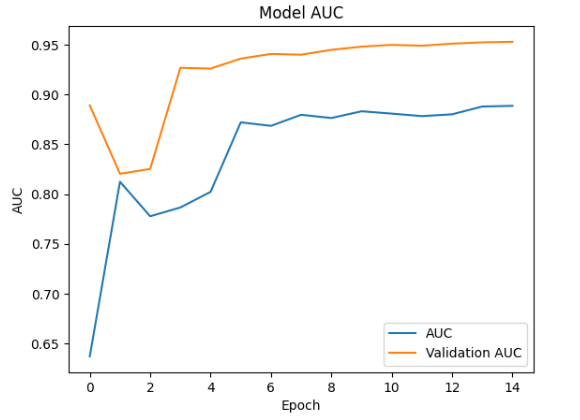

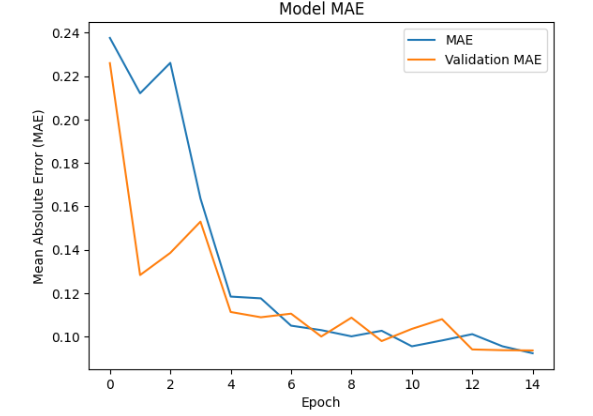

--> The AUC and MAE metrics indicate that the model demonstrates good learning characteristics, with improvements in performance metrics over the training epochs. However, some discrepancies between training and validation metrics may warrant further examination and adjustments to improve generalization.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to extract images from datasets
def extract_images_from_dataset(dataset, num_images):
    images = []
    for img_batch in dataset.take(1):  # Get one batch of images
        for img in img_batch[0][:num_images]:  # Assuming img_batch[0] contains the images
            images.append(img.numpy())
    return np.array(images)

# Function to visualize original, noisy, and predicted images
def visualize_images(original_images, noisy_images, predicted_images, num_images=5):
    plt.figure(figsize=(15, 5 * num_images))

    for i in range(num_images):
        # Original Image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(original_images[i])
        plt.title("Original Image")
        plt.axis("off")

        # Noisy Image
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(noisy_images[i])
        plt.title("Noisy Image")
        plt.axis("off")

        # Predicted Image
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predicted_images[i])
        plt.title("Predicted Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Extract the same images from the original dataset
num_images = 5
original_images = extract_images_from_dataset(test_set, num_images)  # Extract 5 original images

# Create noisy versions from the original images
noisy_images = add_noise(original_images)  # Apply noise to the original images

# Get predictions from the model
predicted_images = model.predict(noisy_images)

# Visualize the original, noisy images, and their predictions
visualize_images(original_images, noisy_images, predicted_images, num_images)


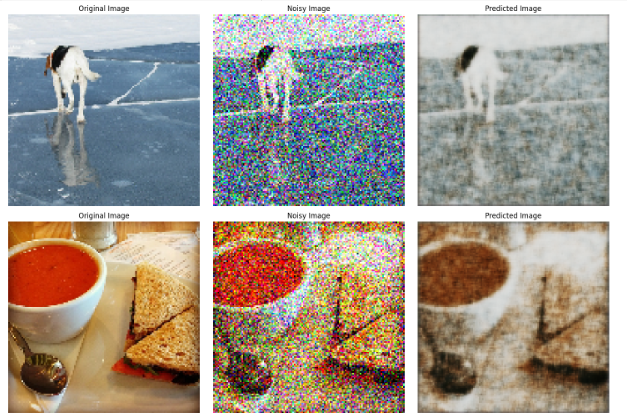

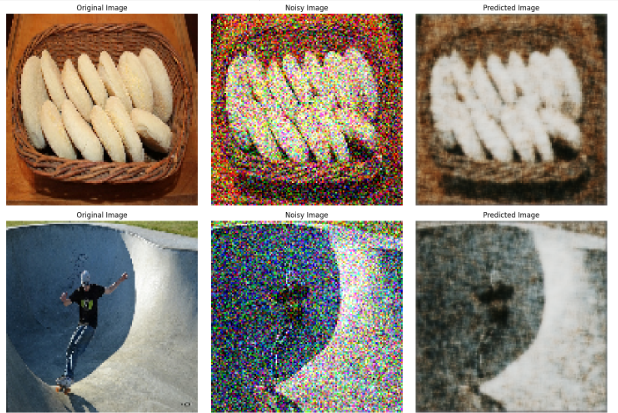

In this model compilation, we use a learning rate of 0.001 with the Adam optimizer to ensure effective training. The combined loss function is implemented to balance multiple objectives during the training process, allowing for improved performance across various tasks. Additionally, we incorporate several metrics, including PSNR, SSIM, and L1, to provide a comprehensive evaluation of the model's performance, ensuring that it captures different aspects of the output quality effectively.

In [ ]:
# Model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer with specified learning rate
    loss=combined_loss,  # Combined loss function for improved training
    metrics=[psnr_metric, ssim_metric, l1_metric]  # Additional metrics for evaluation
)

In [ ]:
# Train the model
history = model.fit(noisy_train_set,
                    epochs=15,  # Adjust based on your needs
                    validation_data=noisy_test_set,
                    callbacks=[tensorboard_callback],
                    verbose=1)  # 1 for progress bar, 0 for silent

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 194s 47s/step - l1_metric: 0.2079 - loss: 0.8363 - psnr_metric: 13.9204 - ssim_metric: 0.3750 - val_l1_metric: 0.1813 - val_loss: 0.7074 - val_psnr_metric: 13.5021 - val_ssim_metric: 0.4738
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 184s 46s/step - l1_metric: 0.1794 - loss: 0.7110 - psnr_metric: 13.6145 - ssim_metric: 0.4694 - val_l1_metric: 0.1175 - val_loss: 0.6059 - val_psnr_metric: 17.1440 - val_ssim_metric: 0.5116
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 205s 47s/step - l1_metric: 0.1252 - loss: 0.6234 - psnr_metric: 16.4345 - ssim_metric: 0.5021 - val_l1_metric: 0.1035 - val_loss: 0.5755 - val_psnr_metric: 17.8693 - val_ssim_metric: 0.5280
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 181s 46s/step - l1_metric: 0.1030 - loss: 0.5652 - psnr_metric: 17.8345 - ssim_metric: 0.5378 - val_l1_metric: 0.1055 - val_loss: 0.5742 - val_psnr_metric: 17.4236 - val_ssim_metric: 0.5313
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 182s 46s/step - l1_metric: 0.1045 - loss: 0.5727 - psnr_metric: 17.5325 - ssim_metric: 0.5320 - val_l1_metric: 0.0974 - val_loss: 0.5618 - val_psnr_metric: 18.1534 - val_ssim_metric: 0.5356
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 183s 46s/step - l1_metric: 0.0962 - loss: 0.5507 - psnr_metric: 18.3617 - ssim_metric: 0.5454 - val_l1_metric: 0.0927 - val_loss: 0.5582 - val_psnr_metric: 18.7167 - val_ssim_metric: 0.5345
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 207s 48s/step - l1_metric: 0.0911 - loss: 0.5547 - psnr_metric: 18.8076 - ssim_metric: 0.5364 - val_l1_metric: 0.0891 - val_loss: 0.5464 - val_psnr_metric: 19.0080 - val_ssim_metric: 0.5427
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 182s 46s/step - l1_metric: 0.0893 - loss: 0.5359 - psnr_metric: 18.9358 - ssim_metric: 0.5535 - val_l1_metric: 0.0859 - val_loss: 0.5339 - val_psnr_metric: 19.2109 - val_ssim_metric: 0.5520
Epoch 9/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 208s 48s/step - l1_metric: 0.0865 - loss: 0.5278 - psnr_metric: 19.1627 - ssim_metric: 0.5589 - val_l1_metric: 0.0805 - val_loss: 0.5315 - val_psnr_metric: 19.7350 - val_ssim_metric: 0.5490
Epoch 10/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 188s 48s/step - l1_metric: 0.0828 - loss: 0.5225 - psnr_metric: 19.5155 - ssim_metric: 0.5603 - val_l1_metric: 0.0813 - val_loss: 0.5212 - val_psnr_metric: 19.6545 - val_ssim_metric: 0.5601
Epoch 11/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 202s 48s/step - l1_metric: 0.0808 - loss: 0.5186 - psnr_metric: 19.6852 - ssim_metric: 0.5621 - val_l1_metric: 0.0790 - val_loss: 0.5205 - val_psnr_metric: 19.8824 - val_ssim_metric: 0.5585
Epoch 12/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 196s 46s/step - l1_metric: 0.0807 - loss: 0.5195 - psnr_metric: 19.6900 - ssim_metric: 0.5611 - val_l1_metric: 0.0777 - val_loss: 0.5186 - val_psnr_metric: 19.9990 - val_ssim_metric: 0.5591
Epoch 13/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 182s 46s/step - l1_metric: 0.0799 - loss: 0.5105 - psnr_metric: 19.7831 - ssim_metric: 0.5695 - val_l1_metric: 0.0756 - val_loss: 0.5101 - val_psnr_metric: 20.1979 - val_ssim_metric: 0.5655
Epoch 14/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 189s 48s/step - l1_metric: 0.0782 - loss: 0.5141 - psnr_metric: 19.9155 - ssim_metric: 0.5641 - val_l1_metric: 0.0744 - val_loss: 0.5010 - val_psnr_metric: 20.2924 - val_ssim_metric: 0.5734
Epoch 15/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 187s 47s/step - l1_metric: 0.0770 - loss: 0.5065 - psnr_metric: 20.0150 - ssim_metric: 0.5705 - val_l1_metric: 0.0750 - val_loss: 0.4999 - val_psnr_metric: 20.2109 - val_ssim_metric: 0.5752

In [ ]:
# PSNR
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['psnr_metric'], label='PSNR')
plt.plot(history.history['val_psnr_metric'], label='Validation PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Model PSNR')
plt.legend()

# SSIM
plt.subplot(1, 3, 2)
plt.plot(history.history['ssim_metric'], label='SSIM')
plt.plot(history.history['val_ssim_metric'], label='Validation SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Model SSIM')
plt.legend()

# L1 Loss
plt.subplot(1, 3, 3)
plt.plot(history.history['l1_metric'], label='L1 Loss')
plt.plot(history.history['val_l1_metric'], label='Validation L1 Loss')
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Model L1 Loss')
plt.legend()

plt.tight_layout()
plt.show()


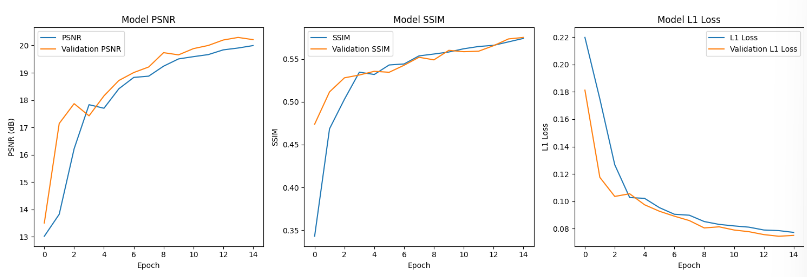


--> The graphs display the performance metrics of the model across 15 epochs. The PSNR (Peak Signal-to-Noise Ratio) shows a steady increase for both training and validation datasets, indicating that the model is effectively enhancing image quality. The SSIM (Structural Similarity Index) also demonstrates an upward trend, suggesting that the model maintains structural integrity in the images over the training period. In contrast, the L1 Loss decreases significantly, particularly in the initial epochs, indicating that the model is learning to minimize error effectively. The slight divergence between training and validation metrics, especially in PSNR and SSIM, suggests that while the model is performing well, there may be minor overfitting, which could be addressed.

In [ ]:
# Get predictions from the model
predicted_images2 = model.predict(noisy_images)

# Visualize the original, noisy images, and their predictions
visualize_images(original_images, noisy_images, predicted_images2, num_images)

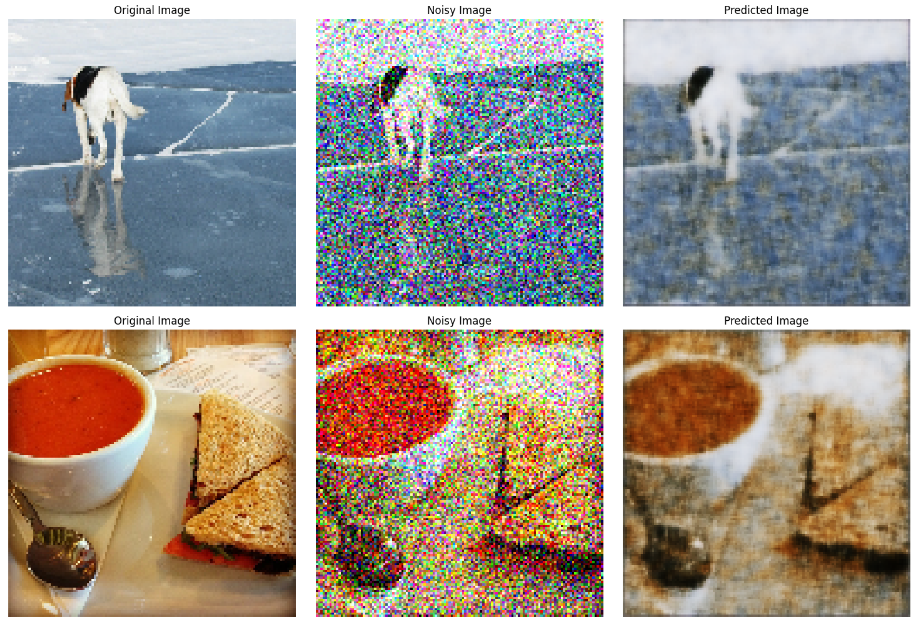

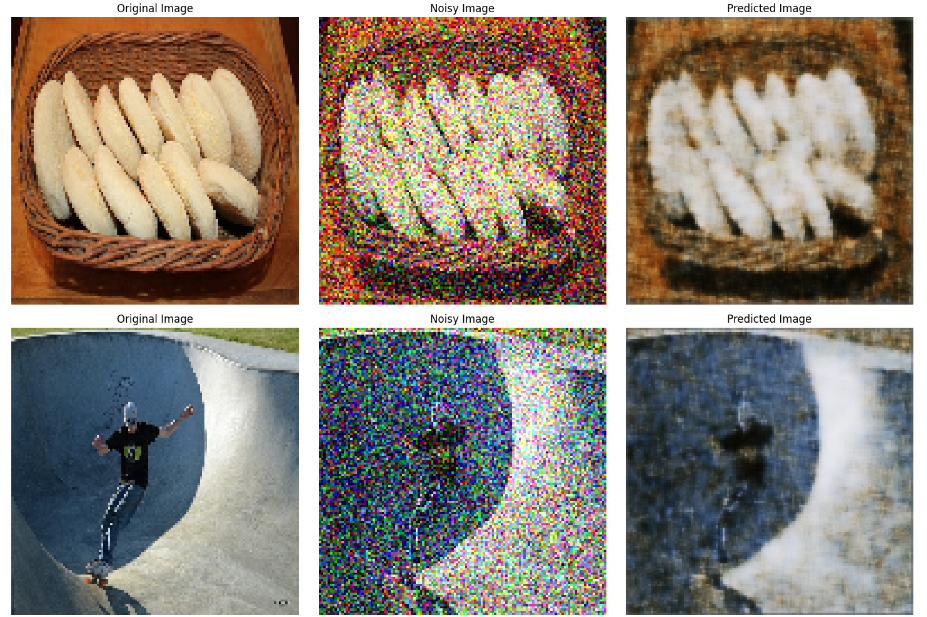

**Applying Gaussian Blur:**

After applying noise reduction, we attempted to implement a blurring technique to further enhance the image quality. Below are the results obtained from this new approach:

In [ ]:
noisy_train_set = train_set.map(lambda x, _: (add_noise(x), x))  # Generate noisy input from clean training data, with the clean target as the original image
blurred_train_set = noisy_train_set.map(lambda x, y: (gaussian_blur(x), y))  # Apply Gaussian blur to the noisy input while keeping the clean target unchanged

noisy_test_set = test_set.map(lambda x, _: (add_noise(x), x))  # Generate noisy input from clean test data, with the clean target as the original image
blurred_test_set = noisy_test_set.map(lambda x, y: (gaussian_blur(x), y))  # Apply Gaussian blur to the noisy input while keeping the clean target unchanged


In [ ]:
# Display the shapes of images and labels in the blurred training set
for images, labels in blurred_train_set.take(1):
    print("Blurred Train Set Shape:", images.shape, labels.shape)

# Display the shapes of images and labels in the blurred test set
for images, labels in blurred_test_set.take(1):
    print("Blurred Test Set Shape:", images.shape, labels.shape)


Blurred Train Set Shape: (32, 128, 128, 3) (32, 128, 128, 3)

Blurred Test Set Shape: (29, 128, 128, 3) (29, 128, 128, 3)

--> These shapes confirm that both datasets are structured correctly, with appropriate batch sizes and image dimensions for the training and testing phases of our model.

Now, after compilation and training, we visualized the images. Overall, the results are good but need improvement, so we will use another approach.

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 195s 47s/step - l1_metric: 0.1766 - loss: 0.6577 - psnr_metric: 15.0541 - ssim_metric: 0.5218 - val_l1_metric: 0.1695 - val_loss: 0.6723 - val_psnr_metric: 13.8890 - val_ssim_metric: 0.4972
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 186s 47s/step - l1_metric: 0.1334 - loss: 0.5963 - psnr_metric: 15.9505 - ssim_metric: 0.5371 - val_l1_metric: 0.1254 - val_loss: 0.5414 - val_psnr_metric: 16.2106 - val_ssim_metric: 0.5840
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 203s 47s/step - l1_metric: 0.1133 - loss: 0.5284 - psnr_metric: 17.1574 - ssim_metric: 0.5855 - val_l1_metric: 0.0864 - val_loss: 0.5039 - val_psnr_metric: 19.3663 - val_ssim_metric: 0.5825
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 191s 49s/step - l1_metric: 0.0854 - loss: 0.4938 - psnr_metric: 19.4890 - ssim_metric: 0.5915 - val_l1_metric: 0.0830 - val_loss: 0.4867 - val_psnr_metric: 19.5784 - val_ssim_metric: 0.5962
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 186s 47s/step - l1_metric: 0.0821 - loss: 0.4817 - psnr_metric: 19.6333 - ssim_metric: 0.6004 - val_l1_metric: 0.0826 - val_loss: 0.4774 - val_psnr_metric: 19.5260 - val_ssim_metric: 0.6052
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 194s 49s/step - l1_metric: 0.0828 - loss: 0.4694 - psnr_metric: 19.5532 - ssim_metric: 0.6136 - val_l1_metric: 0.0745 - val_loss: 0.4586 - val_psnr_metric: 20.3817 - val_ssim_metric: 0.6159
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 194s 47s/step - l1_metric: 0.0756 - loss: 0.4538 - psnr_metric: 20.2441 - ssim_metric: 0.6220 - val_l1_metric: 0.0704 - val_loss: 0.4459 - val_psnr_metric: 20.7695 - val_ssim_metric: 0.6245
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 193s 49s/step - l1_metric: 0.0733 - loss: 0.4460 - psnr_metric: 20.5099 - ssim_metric: 0.6273 - val_l1_metric: 0.0693 - val_loss: 0.4395 - val_psnr_metric: 20.8807 - val_ssim_metric: 0.6298
Epoch 9/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 187s 47s/step - l1_metric: 0.0703 - loss: 0.4365 - psnr_metric: 20.8111 - ssim_metric: 0.6338 - val_l1_metric: 0.0673 - val_loss: 0.4281 - val_psnr_metric: 21.1260 - val_ssim_metric: 0.6392
Epoch 10/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 201s 47s/step - l1_metric: 0.0698 - loss: 0.4306 - psnr_metric: 20.8977 - ssim_metric: 0.6392 - val_l1_metric: 0.0661 - val_loss: 0.4226 - val_psnr_metric: 21.2983 - val_ssim_metric: 0.6435
Epoch 11/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 208s 49s/step - l1_metric: 0.0697 - loss: 0.4222 - psnr_metric: 20.9719 - ssim_metric: 0.6475 - val_l1_metric: 0.0635 - val_loss: 0.4160 - val_psnr_metric: 21.6451 - val_ssim_metric: 0.6475
Epoch 12/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 203s 49s/step - l1_metric: 0.0664 - loss: 0.4193 - psnr_metric: 21.3065 - ssim_metric: 0.6471 - val_l1_metric: 0.0625 - val_loss: 0.4073 - val_psnr_metric: 21.7532 - val_ssim_metric: 0.6552
Epoch 13/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 187s 47s/step - l1_metric: 0.0656 - loss: 0.4119 - psnr_metric: 21.4174 - ssim_metric: 0.6538 - val_l1_metric: 0.0616 - val_loss: 0.4012 - val_psnr_metric: 21.8831 - val_ssim_metric: 0.6604
Epoch 14/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 192s 49s/step - l1_metric: 0.0640 - loss: 0.4058 - psnr_metric: 21.6485 - ssim_metric: 0.6583 - val_l1_metric: 0.0611 - val_loss: 0.3955 - val_psnr_metric: 21.9105 - val_ssim_metric: 0.6657
Epoch 15/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 193s 49s/step - l1_metric: 0.0648 - loss: 0.3997 - psnr_metric: 21.5494 - ssim_metric: 0.6650 - val_l1_metric: 0.0605 - val_loss: 0.3890 - val_psnr_metric: 22.0377 - val_ssim_metric: 0.6715

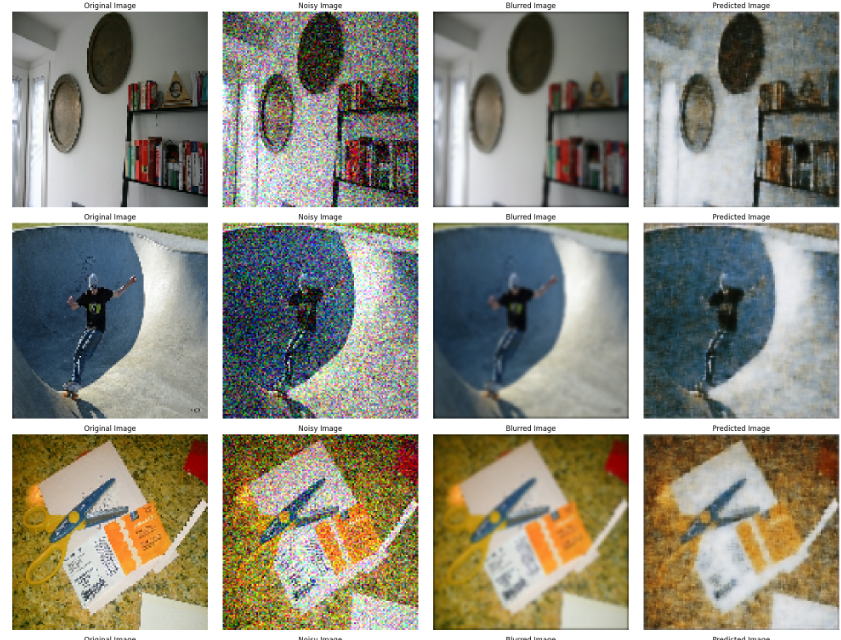

To enhance the model's performance, we modified the architecture by implementing several key changes. We maintained the U-Net structure but replaced the activation function with Leaky ReLU, utilizing an alpha of 0.2 for improved gradient flow during training. Additionally, we incorporated Batch Normalization after each convolutional layer to stabilize and accelerate training by normalizing the outputs.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model2(input_shape):
    # Define input layer
    inputs = layers.Input(shape=input_shape)

    # **Contracting Path**
    # First convolutional block
    c1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.LeakyReLU(alpha=0.2)(c1)
    c1 = layers.Conv2D(64, (3, 3), padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.LeakyReLU(alpha=0.2)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Second convolutional block
    c2 = layers.Conv2D(128, (3, 3), padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.LeakyReLU(alpha=0.2)(c2)
    c2 = layers.Conv2D(128, (3, 3), padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.LeakyReLU(alpha=0.2)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Third convolutional block
    c3 = layers.Conv2D(256, (3, 3), padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.LeakyReLU(alpha=0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.LeakyReLU(alpha=0.2)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # **Bottleneck**
    c4 = layers.Conv2D(512, (3, 3), padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.LeakyReLU(alpha=0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.LeakyReLU(alpha=0.2)(c4)

    # **Expanding Path**
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), padding='same')(u5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.LeakyReLU(alpha=0.2)(c5)
    c5 = layers.Conv2D(256, (3, 3), padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.LeakyReLU(alpha=0.2)(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.LeakyReLU(alpha=0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.LeakyReLU(alpha=0.2)(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.LeakyReLU(alpha=0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.LeakyReLU(alpha=0.2)(c7)

    # **Output Layer**
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c7)  # 3 channels for RGB output

    # Create the model
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

visualkeras.layered_view(unet_model2((128, 128, 3)), to_file=None, legend=True)


In [ ]:
# Define input shape
input_shape = (128, 128, 3)  # Example input shape
# Create the U-Net model
model4 = unet_model2(input_shape)


In [ ]:
# Print model summary
model4.summary()

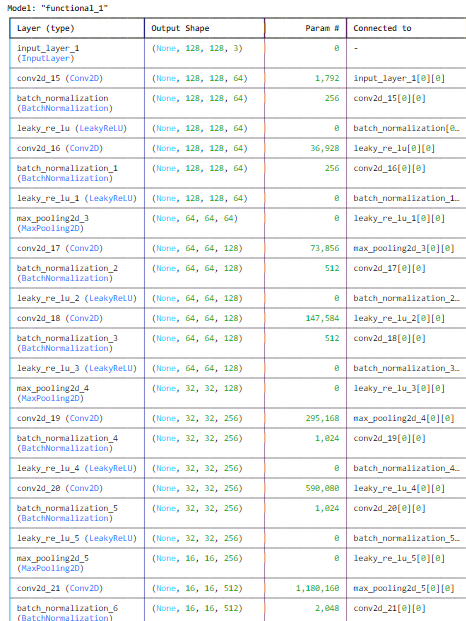

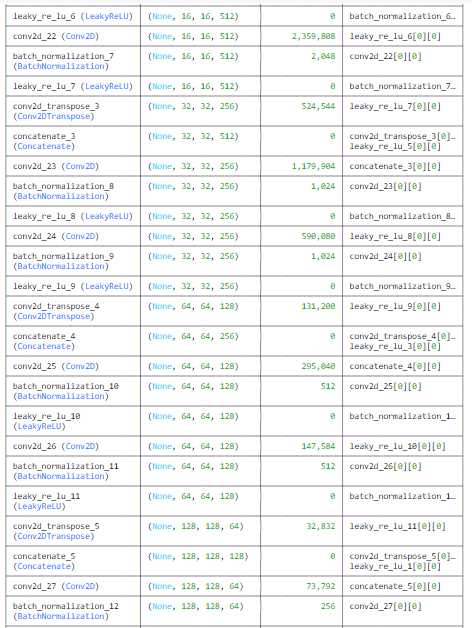

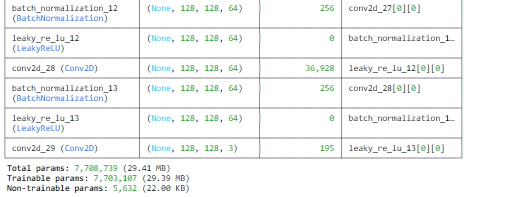

After compiling and training the model, we retrieved the performance metrics for the last epoch, specifically focusing on PSNR, SSIM, and L1 Loss. 

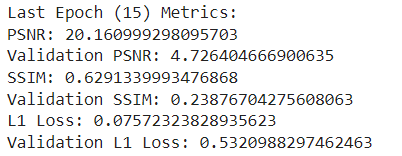

The final PSNR was observed to be low, indicating that the model struggled to maintain high image quality. Similarly, the SSIM value was not satisfactory, reflecting poor structural similarity in the reconstructed images compared to the originals. Additionally, the L1 Loss, which quantifies the reconstruction error, remained high, suggesting that the model failed to accurately predict the target outputs. Given these disappointing results across all key metrics, we concluded that the model's performance was inadequate and decided not to proceed with its use.

## Comparing different architectures 
Our team divided up the work to experiment with different autoencoder architectures. The aim is to find the model that best reconstructs our noisy images. We test the models and register our results to make a decision. Note that each result was obtained with the parameters :

- Image width: 128
- Image height: 128
- Batch size: 16
- Number of epochs: 100
- Noise factor: 0.3

<em style="color:red">Note that our team tested a fully connected architecture which did not deliver good results. This experiment can be found in the following notebook 

[./L2_Fully_Connected_Dense_autoencoder](./L2_Fully_Connected_Dense_autoencoder.ipynb)</em>

In [51]:
print('MSE:', \
autoencoder_mse.evaluate(noisy_test_set))
print('L1:', \
autoencoder_l1.evaluate(noisy_test_set))
print('SSIM:', \
autoencoder_ssim.evaluate(noisy_test_set))
print('Hybride:', \
autoencoder_hybride.evaluate(noisy_test_set))
print('AUG MSE:', \
autoencoder_augmented_mse.evaluate(noisy_test_ds_augmented))
print('AUG L1:', \
autoencoder_augmented_l1.evaluate(noisy_test_ds_augmented))
print('AUG SSIM:', \
autoencoder_augmented_ssim.evaluate(noisy_test_ds_augmented))
print('AUG Hybride:', \
autoencoder_augmented_hybride.evaluate(noisy_test_ds_augmented))

Here's our original test image. The results should be as accurate as possible.


|                        Model                       |          Description         | Execution time | PSNR metric (Higher=Better) | SSIM Metric (Higher=Better) | L1 (Lower=Better) | Result on image test |
|:--------------------------------------------------:|:----------------------------:|:--------------:|:---------------------------:|-----------------------------|-------------------|:--------------------:|
| [Model_0](#aug-mixed-loss)|3 convolutionnal layers and moderate amount of filters| + |23.0029|0.6772|0.0507|![results](results/model_0.png)|
| [Model_1](./Models.ipynb#model-1)|4 convolutionnal layers and a lot of filters| +++ |19.3408|0.4582|0.0786|![results](results/model_1.png)|
| [Model_2](./Models.ipynb#model-2)|Denoising autoencoder with a latent bottleneck|+|12.4194|0.3290|0.1995|![results](results/model_2.png)|
| [Model_3](./Models.ipynb#model-3)|Convolutional layers, batch normalization and </br> transposed convolutions|+++|23.5697|0.7304|0.0500|![results](results/model_3.png)|
| [Model_4](./Models.ipynb#model-4)|Convolutional layers and includes both max </br> pooling and upsampling layers to downsample|++|23.8654|0.7157|0.0438|![results](results/model_4.png)|
| [Model_5](./Models.ipynb#model-5)|3 convolutionnal layers and a lot of filters|++|23.3032|0.6926|0.0494|![results](results/model_5.png)|
| [Model_6](./Models.ipynb#model-6)|Batch normalization and ReLU activation functions </br> after each convolutional layer|+++|21.7795|0.6602|0.0595|![results](results/model_6.png)|                             |                   |                      |
| [ Model_7 ]( #mse )                                | MSE Loss                     | 54.0s          | 19.62                       | 0.5220                      | 0.0747            |                      |
| [ Model_8 ]( #l1-loss )                            | L1 Loss                      | 43.2s          | 19.76                       | 0.522                       | 0.0698            |                      |
| [ Model_9 ]( #ssim )                               | SSIM Loss                    | 46.9s          | 18.97                       | 0.5759                      | 0.0814            |                      |
| [ Model_10 ]( #mixed-loss-function )               | Mix Loss                     | 45.4s          | 19.91                       | 0.5789                      | 0.07              |                      |
| [ Model_11 ]( #aug-mse)                           | MSE Loss, augmented dataset  | 1m 13.3s       | 22.94                       | 0.6368                      | 0.0519            |                      |
| [ Model_12 ]( #aug-l1-loss )                       | L1 Loss, augmented dataset   | 1m 9.3s        | 22.3                        | 0.6363                      | 0.055             |                      |
| [ Model_13 ]( #aug-ssim )                          | SSIM Loss, augmented dataset | 1m 12.8s       | 21.33                       | 0.681                       | 0.0642            |                      |
| [ Model_14 ]( #aug-mixed-loss )                    | Mix Loss, augmented dataset  | 1m 12.4s       | 22.4                        | 0.681                       | 0.055             |                      |
| [Model_15](#aug-vae-mse ) | Variational Autoencoders using mse as loss function with augmented data|1 min| 12.4547 | 0.3264 |0.2074|                   |
| [Model_16](#aug-vae-l1)| Variational Autoencoders using L1 Loss as loss function with augmented data |  1 min | 12.7649 |  0.3299 |0.1971|                      |
| [Model_17](#aug-vae-ssim)|  Variational Autoencoders using SSIM as loss function with augmented data |1 min |12.8139 |   0.3299 |  0.1911 |                      |
| [Model_18](#aug-vae-mixed-loss)|  Variational Autoencoders using Combine Loss as loss function with augmented data |1 min |12.8857 | 0.3361 |  0.1877 |                      |
| [Model_19](#u-net-architecture)| 7 convolutional layers with filters ranging from 64 to 512. It utilizes techniques such as 2D convolution, max pooling, and transposed convolution for upsampling. The ReLU activation function is applied in all convolutional layers, and a sigmoid activation is used in the output layer | + | 19.9939 | 0.5740 |  0.0772 |   
| [Model_20](#u-net-architecture)|20 convolutional layers, each with filters ranging from 64 to 512. The contracting path includes three downsampling blocks with 64, 128, and 256 filters, using Batch Normalization and Leaky ReLU activations (alpha = 0.2) .The expansive path uses transposed convolutions for upsampling and concatenates with the corresponding feature mapsc from the contracting path. The final layer is a 1x1 convolution to produce a 3-channel RGB output. | + | 20.0936 | 0.6277 |  0.5321 |


## Experiment Conclusion
We have tested different autoencoder architectures and loss functions to find the best model for denoising images. We have compared the performance of the models using metrics such as PSNR, SSIM, and L1 loss. We have also evaluated the models on a test image to see how well they can reconstruct the original image from a noisy version.

Based on the results, we can conclude that the model with the best performance is Model_4, which uses convolutional layers, batch normalization and transposed convolutions with both max pooling and upsampling layers to downsample. This model achieves the highest PSNR and SSIM scores and the lowest L1 loss, indicating that it can effectively denoise images while preserving important features.

<div style="text-align: center;">
    <img src="img/original_test.png" alt="Original Test Image" style="max-width: 100%; height: auto;" />
    <img src="img/noised_test.png" alt="Noised Test Image" style="max-width: 100%; height: auto;" />
    <img src="img/denoised_test.png" alt="Denoised Test Image" style="max-width: 100%; height: auto;" />
</div>

The results show that the denoised image retains the essential features of the original while effectively reducing noise. The denoising process is successful, as indicated by the high PSNR and SSIM values, which reflect the model's ability to reconstruct the image accurately.

However, it is important to note that the colors in the denoised image are not as vibrant as those in the original. This could be attributed to the use of the SSIM loss function, which focuses on structural similarity rather than exact pixel-wise color fidelity. This approach often results in images that may appear less colorful while still preserving important details.

We should also consider that treating the color information not purely in the RGB space but in a different color space, such as YCbCr or LAB, could yield better results. These spaces separate luminance from chrominance, allowing the model to focus on preserving color details more effectively.

Interestingly, one of the models utilizing extensive batch normalization produced a denoised image with more accurate color representation. This suggests that incorporating batch normalization might help in maintaining the richness of color while still achieving effective denoising (model 6).

<div style="text-align: center;">
    <img src="img/denoised_batchnormalization.png" alt="Denoised model 6 Test Image" style="max-width: 100%; height: auto;" />
</div>

## Annexes

### Model 1

In the autoencoder below, we try adding a convolution layer with pooling in the encoder __AND__ the decoder.

We then have 4 convolution layers in the encoder, each with the following number of filters: [`64`, `128`, `256`, `512`].

By increasing the number of layers and filters, we try to capture more complex and detailed features. On the other hand, each pooling layer reduces the spatial resolution of the image. In this case, although it helps us, there's a risk of losing fine details such as patterns. This can affect the quality of our denoising.

What's more, the model's complexity will slow down training, as we also increase computational requirements.

The final risk with such an architecture is that, with our reduced dataset, the model has a high chance of overfitting.

In [214]:
def build_dae_4l(input_shape=(128, 128, 3)):
    # Encoder
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x) 
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  

    # Decoder
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x) 
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x) 
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x) 
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder


In [ ]:
dae_4l = build_dae_4l(input_shape=(image_h, image_w, 3))
dae_4l.compile(optimizer='adam', loss=combined_loss, metrics=[psnr_metric, ssim_metric, l1_metric])
dae_4l.summary()

In [ ]:
dae_4l_history = dae_4l.fit(
    noisy_train_ds_augmented, 
    epochs=EPOCHS, 
    validation_data=noisy_test_ds_augmented, 
    callbacks=[tensorboard_callback]
    )

In [ ]:
plot_history(dae_4l_history, EPOCHS, metric='psnr_metric')

In [ ]:
display_images_results(test_ds_augmented, noisy_test_ds_augmented, dae_4l, 5)

### Model 2
DAE with latent space

In [220]:
# Build the Denoising Autoencoder (DAE) model with a latent bottleneck
def build_denoising_autoencoder_with_latent(input_shape=(128, 128, 3), latent_dim=10):
    # Encoder
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Flatten and add the bottleneck layer
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu', name='latent_bottleneck')(x)

    # Decoder
    x = layers.Dense(16 * 16 * 128, activation='relu')(latent)  # Reshape back to match the previous encoder layer
    x = layers.Reshape((16, 16, 128))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [ ]:
autoencoder_latent = build_denoising_autoencoder_with_latent(input_shape=(image_h, image_w, 3))
autoencoder_latent.compile(optimizer='adam', loss=combined_loss, metrics=[psnr_metric, ssim_metric, l1_metric])

autoencoder_latent.summary()

In [ ]:
visualkeras.layered_view(autoencoder_latent, to_file=None, legend=True)

In [ ]:
# Train the autoencoder
history_latent = autoencoder_latent.fit(noisy_train_ds_augmented, epochs=EPOCHS, validation_data=noisy_test_ds_augmented,
                          callbacks=[tensorboard_callback])

In [ ]:
plot_history(history_latent, EPOCHS, metric='psnr_metric')

In [ ]:
display_images_results(test_set, noisy_test_set, autoencoder_latent, 5)

### Model 3

In the following architecture, we seek to capture even more complex information in noisy images. The latter also seeks to reconstruct a noisy version of an image via a series of convolutions in the encoder. However, we subsequently use a convolution transposition operation (`keras.layers.Conv2DTranspose`) in the decoder.

The first layer of this encoder is a classic covolution layer containing 32 filters. However, the second layer is a [batch normalization layer](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) (`keras.layers.BatchNormalisation`) which will stabilize the training. In fact, this is a technique that will solve certain problems linked to training, such as the [__covariate shift__](https://www.seldon.io/what-is-covariate-shift#:~:text=Covariate%20shift%20occurs%20when%20the,accuracy%20will%20be%20significantly%20lower.).

Batch Normalization normalizes a layer's neuron activations by calculating the __mean__ and __standard deviation__ of activations over a batch of examples. Each neuron in the layer receives inputs that are scaled and refocused, helping to __reduce the variance__ of activations between different layers of the network.

Our encoder also includes 2 convolution layers in which __strides__ will reduce the spatial dimension. These stripes designate the way in which the convolution filter moves over the image. A stride of `(2, 2)` as in our model means that the filter moves 2 pixels each time (horizontally and vertically), instead of 1 pixel. This reduces the size of the image by half after each convolutional layer, without adding any extra computation.

Here we use it instead of pooling, because although pooling layers are useful for reducing dimensionality and computation time, they can lead to information loss and increased complexity. In the case of the architecture you're using, the use of strides enables dimensional reduction while retaining some of the relevant information, which can potentially improve model performance.

The last layer of the encoder passes an encoded representation of the reduced-size image to the decoder, which is made up of convolution transposition layers that work like the inverse of normal convolutions, while increasing the image size with strides (like the upsampling seen previously).

While this architecture contains many positive points, such as the use of Batch Normalization and Strides, a more parametric approach than maxpooling, it also has the weakness of accumulating parameters via convolutions and convolutional transpositions. What's more, the number of layers and their large number of filters will increase the time and complexity of the model.

In [228]:
def build_deeper_denoising_autoencoder(input_shape=(128, 128, 3)):
    input_img = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    encoded = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Decoder
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(encoded)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [ ]:
# Compile the model as before
deeper_autoencoder = build_deeper_denoising_autoencoder(input_shape=(image_h, image_w, 3))
deeper_autoencoder.compile(optimizer='adam', loss=combined_loss, metrics=[psnr_metric, ssim_metric, l1_metric])

deeper_autoencoder.summary()

# Train the model with augmentation
history_deep = deeper_autoencoder.fit(noisy_train_ds_augmented, epochs=EPOCHS, validation_data=noisy_test_ds_augmented, 
                                       callbacks=[tensorboard_callback])

plot_history(history_deep, EPOCHS, metric='psnr_metric')

In [ ]:
visualkeras.layered_view(deeper_autoencoder, to_file=None, legend=True)

In [ ]:
display_images_results(test_set, noisy_test_set, deeper_autoencoder, 5)

### Model 4

In [232]:
def build_denoising_autoencoder_with_pooling(input_shape=(128, 128, 3)):
    input_img = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Pooling layer added here
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    encoded = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Decoder
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(encoded)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # Upsampling layer added here
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder


In [ ]:
# Compile the model as before
deeper_autoencoder_pool = build_denoising_autoencoder_with_pooling(input_shape=(image_h, image_w, 3))
deeper_autoencoder_pool.compile(optimizer='adam', loss='mean_squared_error', metrics=[psnr_metric, ssim_metric, l1_metric])

deeper_autoencoder_pool.summary()

In [ ]:
# Train the model with augmentation
history_deep_pool = deeper_autoencoder_pool.fit(noisy_train_ds_augmented, epochs=100, validation_data=noisy_test_ds_augmented, 
                                       callbacks=[tensorboard_callback])

In [ ]:
plot_history(history_deep_pool, EPOCHS, metric='psnr_metric')


In [ ]:
display_images_results(test_set, noisy_test_set, deeper_autoencoder_pool, 5)

### Model 5

In [ ]:
def build_autoencoder_3l_more_filters(input_shape=(128, 128, 3)):
    # Encoder
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

autoencoder_3l_more_filters = build_autoencoder_3l_more_filters(input_shape=(image_h, image_w, 3))
autoencoder_3l_more_filters.compile(optimizer='adam', loss=combined_loss, metrics=[psnr_metric, ssim_metric, l1_metric])

autoencoder_3l_more_filters.summary()
visualkeras.layered_view(autoencoder_3l_more_filters, to_file=None, legend=True)

In [ ]:
history_3l_more_filters = autoencoder_3l_more_filters.fit(noisy_train_ds_augmented, epochs=EPOCHS, validation_data=noisy_test_ds_augmented, callbacks=[tensorboard_callback])

In [ ]:
plot_history(history_3l_more_filters, EPOCHS, metric='psnr_metric')

In [ ]:
display_images_results(test_set, noisy_test_set, autoencoder_3l_more_filters, 5)

### Model 6 
Batch normalization

The following model is also based on the classic architecture of an autoencoder, with an encoder and decoder that extract features to reduce the dimensionality of the image before reconstructing it.

It is composed of convolution layers to extract features. Each layer has an increasing number of filters, enabling increasingly complex features to be learned. Each of these layers will be followed by a MaxPooling layer to reduce the feature size by 2. This will reduce the amount of data to be processed while retaining the most significant features.

However, unlike the first model, these layers will be interspersed with BatchNormalization layers to stabilize training and reduce the risk of overlearning, as well as layers using the __ReLu__ activation function (`keras.layers.Activation`). This makes it possible to capture non-linearities in the data.

As before, the decoder is made up of deconvulsion layers (UpSampling) and convolutions, but this time with ReLU activation. Each convolution layer in the decoder is followed by Batch Normalization and ReLU, which improves the network's ability to learn details during reconstruction.

Repeated use of Batch Normalization helps to make training more stable and faster, which is particularly useful for autoencoders. However, the architecture is relatively complex, with many layers. If the dataset is small or not very varied, this can increase the risk of overlearning.

In [176]:
def build_denoising_autoencoder_batch_norm(input_shape=(128, 128, 3)):
    # Encoder
    input_img = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (3, 3), padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(256, (3, 3), padding='same')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D((2, 2))(x)

    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [ ]:
# Build and compile the model
autoencoder_norm = build_denoising_autoencoder_batch_norm(input_shape=(128, 128, 3))
autoencoder_norm.compile(optimizer='adam', loss=combined_loss, metrics=[psnr_metric, ssim_metric, l1_metric])

# Model summary
autoencoder_norm.summary()

# Visualize the model
visualkeras.layered_view(autoencoder_norm, to_file=None, legend=True)

In [ ]:
norm_history = autoencoder_norm.fit(noisy_train_ds_augmented, epochs=EPOCHS, validation_data=noisy_test_ds_augmented, callbacks=[tensorboard_callback])

## Visualisation in Tensorbard

In [ ]:
%tensorboard --logdir=logs/fit

## References
- https://www.geeksforgeeks.org/denoising-autoencoders-in-machine-learning/ 
- https://pyimagesearch.com/2020/02/24/denoising-autoencoders-with-keras-tensorflow-and-deep-learning/ 
- https://research.nvidia.com/sites/default/files/pubs/2017-03_Loss-Functions-for/NN_ImgProc.pdf
- https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739 
- https://www.seldon.io/what-is-covariate-shift#:~:text=Covariate%20shift%20occurs%20when%20the,accuracy%20will%20be%20significantly%20lower.